<a href="https://colab.research.google.com/github/joiortega1/Deep_Learning/blob/main/Tarea3/Tarea3_JaimeOrtega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3
## Transferencia de conocimiento y redes recurrentes
- Ortega Ibarra Jaime Jesús

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

1. Entrena modelos de regresi ́on para predecir edades en el conjunto de datos UTKFace. La
soluci ́on debe cumplir con los siguientes puntos:

- Implementa la tuber ́ıa de datos usando el conjunto de rostros alineados y recortados1


- Agrega acrecentamiento de datos usando un espejeo horizontal.
- Particiona aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %.
- Usando transferencia de conocimiento, entrena un modelo reentrenando solo la  ́ultima
capa.
- Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red.
- Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

## Preparamos

In [1]:
! pip install torchinfo

## Importamos librerías necesarias

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as tvm
import torchvision.transforms as T
from torch.utils.data import DataLoader
from os.path import join
import os
import random
from torchinfo import summary
from tqdm import tqdm
from itertools import islice as take
from sklearn.metrics import r2_score


## Descargamos nuestros datos

In [3]:
!mkdir -p {'datos'}
!wget -nc {'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'} -O {'datos/UTKFace.tar.gz'}
!tar -zxf {'datos/UTKFace.tar.gz'} -C {'datos'}

File ‘datos/UTKFace.tar.gz’ already there; not retrieving.


## Auxiliares

In [4]:
path = 'datos/UTKFace/'
IMG_SIZE = 244
BATCH_SIZE = 32

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed()

Construyendo nuestro conjunto de datos

In [5]:
class generate_dataset:
  def __init__(self, path, subset, transform=None):
    self.path = path
    self.transform = transform
    self.subset = subset

    images = sorted(os.listdir(self.path))
    random.Random(0).shuffle(images)
    ages = [int(image.split('_')[0]) for image in images]

    size_train = int(len(images)*0.8)
    if self.subset == 'train':
      self.images, self.ages = images[:size_train], ages[:size_train]
    else:
      self.images, self.ages = images[size_train:], ages[:size_train]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    filepath = self.images[idx]
    img = Image.open(join(self.path,filepath))
    if self.transform is not None:
      img = self.transform(img)
    age = self.ages[idx]

    return img, age

In [6]:
df_train = generate_dataset(path, 'train')
print(f'Longitud: {len(df_train)}')

Longitud: 18966


## Visualizamos un ejemplo

In [7]:
def show_image(df):
  image, age = df_train[random.randint(1, 100)]
  print(f'    Age = ', age)
  return image

    Age =  45


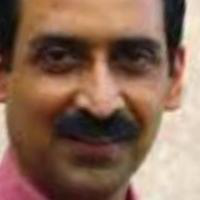

In [8]:
show_image(df_train)

## Transformación de nuestros Datos

Pese a la construcción de nuestro dataset, debemos definir nuestras transformaciones, sinedo incluído el espejeo horizontal de manera aleatoria.

In [9]:
# transformacion Train
trn_transform = T.Compose([
    # Redimension
    T.Resize(IMG_SIZE),
    # Espejeo
    T.RandomHorizontalFlip(),
    # Convertimos a Tensor
    T.ToTensor(),  
    # Estandarizamos
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
train_df = generate_dataset(path, 'train', transform = trn_transform)
trn_dl = DataLoader(dataset=train_df, batch_size=BATCH_SIZE, num_workers=2)

In [10]:
# transformacion Test
tst_transform = T.Compose([
    # Redimension
    T.Resize(IMG_SIZE),
    # Convertimos a Tensor
    T.ToTensor(),  
    # Estandarizamos
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
test_df = generate_dataset(path, 'test', transform = tst_transform)
tst_dl = DataLoader(dataset=test_df, batch_size=BATCH_SIZE, num_workers=2)

In [11]:
print(f'Longitud Train: {len(train_df)}')
print(f'Longitud Test: {len(test_df)}')

Longitud Train: 18966
Longitud Test: 4742


## Funciones de visualización

In [12]:
def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    x = x.permute(0, 2, 3, 1)
    x = (x.numpy()).astype(np.uint8)
    display_grid(x, titles, rows, cols, figsize)

Visualizando Train

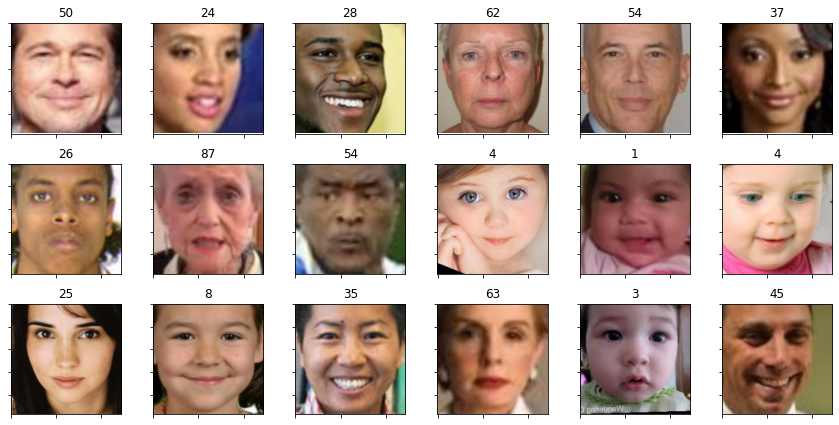

In [13]:
image, age = next(iter(trn_dl))
display_batch(image, age.numpy(), 3, 6)

Visualizando Test

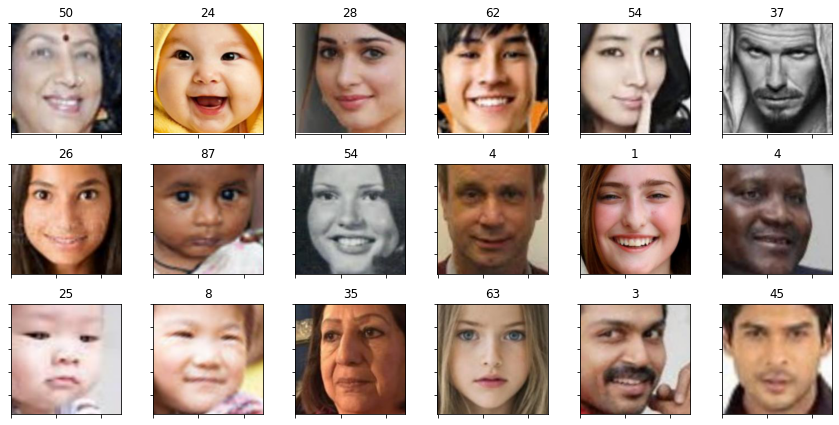

In [14]:
image, age = next(iter(tst_dl))
display_batch(image, age.numpy(), 3, 6)

## Modelo
Basándonos en la libreta de la clase $3b$, he optado por utilizar modelo preentrenado en ImageNet de Torchvision, en este caso: $Shufflenet V2$

In [15]:
tvm.shufflenet_v2_x0_5(pretrained=True)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

## Carga de pesos y transferencia

In [16]:
class SimpleLocNet(nn.Module):
    
    def __init__(self, pretrained):
        super(SimpleLocNet, self).__init__()
        
        # cargamos el modelo
        self.cnn = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        # remplazamos la FC para dejar intactas 
        # las características (diablito)
        self.cnn.fc = nn.Identity()

        in_features = 1024
        # armamos la capa de regresión
        self.reg = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Linear(in_features, 1)
        )
    
    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.cnn(x)
        # [N, 1024] => [N, 4]
        x = self.reg(x)
        return x
    
model = SimpleLocNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model.eval()

In [17]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), device='cuda', verbose=0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                        Output Shape              Param #
SimpleLocNet                                  --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 24, 122, 122]         (648)
│    │    └─BatchNorm2d: 3-2                  [1, 24, 122, 122]         (48)
│    │    └─ReLU: 3-3                         [1, 24, 122, 122]         --
│    └─MaxPool2d: 2-2                         [1, 24, 61, 61]           --
│    └─Sequential: 2-3                        [1, 48, 31, 31]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 31, 31]           (2,400)
│    │    └─InvertedResidual: 3-5             [1, 48, 31, 31]           (1,512)
│    │    └─InvertedResidual: 3-6             [1, 48, 31, 31]           (1,512)
│    │    └─InvertedResidual: 3-7             [1, 48, 31, 31]           (1,

## Entrenamiento

In [18]:
!nvidia-smi

Sun Jun 20 00:50:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   1110MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
_ = model.eval()

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

## Ciclo de Entrenamienot

### Funciones de entrenamiento
 Basándonos en la libreta 3a vista en clase

In [22]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch[0].to(device)
        y_true = batch[1].to(device)
        # computamos logits
        y_lgts = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_lgts, y_true.view(-1,1).float())
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses, r2s = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch[0].to(device)
            y_true = batch[1].to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # computamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # computamos la pérdida
            loss = F.mse_loss(y_lgts, y_true.view(-1,1).float())
            # computamos la exactitud
            r2 = r2_score(y_true.detach().cpu().numpy(), 
                          y_lgts.detach().cpu().numpy())

            # guardamos históricos
            losses.append(loss.item())
            r2s.append(r2)

        loss = np.mean(losses)
        r2s = np.mean(r2)
        
        return loss, r2s

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl, epochs,
          trn_batches=None, val_batches=None, run_dir="checkpoints"):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_r2 = 0
    loss_trn = [] 
    r2_trn = []
    loss_tst = []
    r2_tst = []
    for epoch in range(epochs):
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_r2 = eval_epoch(trn_dl, model, device, trn_batches) 
        loss_trn.append(trn_loss)
        r2_trn.append(trn_r2)
        # evaluamos la época en validación
        val_loss, val_r2 = eval_epoch(val_dl, model, device, val_batches)
        loss_tst.append(val_loss)
        r2_tst.append(val_r2)
        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_r2 > best_r2:
            best_r2 = val_r2
            save_check_point(model, epoch, run_dir)

    return loss_trn, r2_trn, loss_tst, r2_tst

In [23]:
loss_trn, r2_trn, loss_tst, r2_tst = train(model, trn_dl, tst_dl, epochs=10)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16,9))
pd.DataFrame(losses).plot(ax=ax[0])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
pd.DataFrame(r2s).plot(ax=ax[1])
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"$r^2$")

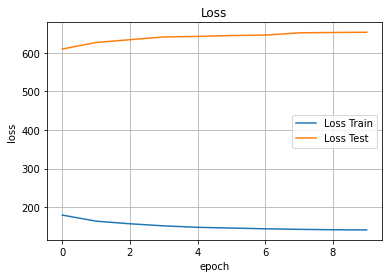

In [27]:
plt.plot(loss_trn, label='Loss Train')
plt.plot(loss_tst, label='Loss Test')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

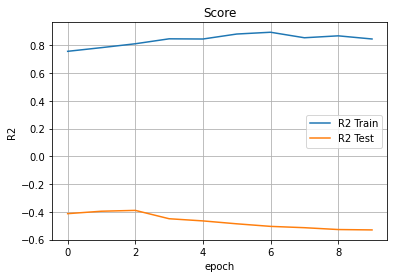

In [28]:
plt.plot(r2_trn, label='R2 Train')
plt.plot(r2_tst, label='R2 Test')
plt.title('Score')
plt.ylabel('R2')
plt.xlabel('epoch')
plt.legend()
plt.grid()
plt.show()

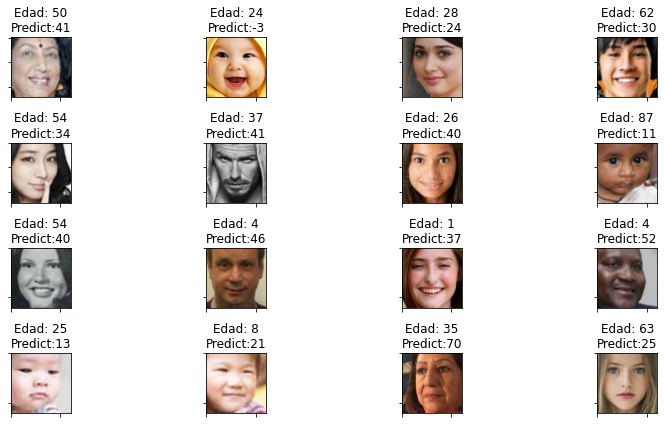

In [35]:
model.to("cpu")
with torch.no_grad():
  x, y_true = next(iter(tst_dl))
  y_pred = model(x).round()
  titles = []
  for age, predict in zip(y_true, y_pred.flatten()):
    label = f'Edad: {age}\nPredict:{int(predict)}'
    titles.append(label)
  display_batch(x, titles, 4, 4)

In [36]:
model_2 = tvm.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [39]:
model_2 = SimpleLocNet(True)

# congelado de parámetros de la CNN
for param in model.cnn.parameters():
    param.requires_grad = False
# congelado de estadísticas de todo el modelo
_ = model_2.eval()

In [41]:
summary(model_2, (1, 3, IMG_SIZE, IMG_SIZE), device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
SimpleLocNet                                  --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 122, 122]         --
│    │    └─Conv2d: 3-1                       [1, 24, 122, 122]         648
│    │    └─BatchNorm2d: 3-2                  [1, 24, 122, 122]         48
│    │    └─ReLU: 3-3                         [1, 24, 122, 122]         --
│    └─MaxPool2d: 2-2                         [1, 24, 61, 61]           --
│    └─Sequential: 2-3                        [1, 48, 31, 31]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 31, 31]           2,400
│    │    └─InvertedResidual: 3-5             [1, 48, 31, 31]           1,512
│    │    └─InvertedResidual: 3-6             [1, 48, 31, 31]           1,512
│    │    └─InvertedResidual: 3-7             [1, 48, 31, 31]           1,512
│    └─

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_2 = model_2.to(device)

cuda


In [45]:
loss_trn, r2_trn, loss_tst, r2_tst = train(model_2, trn_dl, tst_dl, epochs=10)

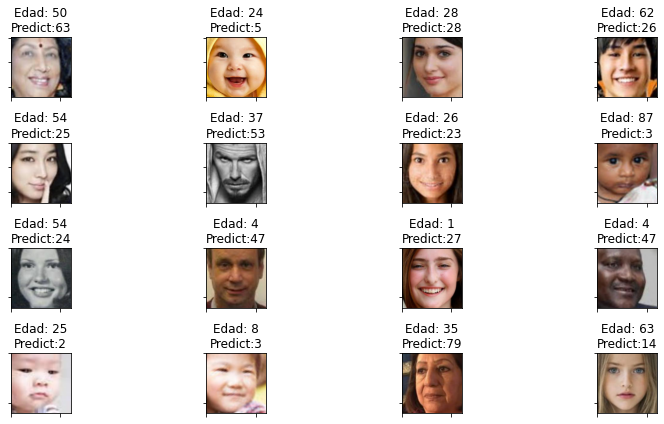

In [46]:
model_2.to("cpu")
with torch.no_grad():
  x, y_true = next(iter(tst_dl))
  y_pred = model_2(x).round()
  titles = []
  for age, predict in zip(y_true, y_pred.flatten()):
    label = f'Edad: {age}\nPredict:{int(predict)}'
    titles.append(label)
  display_batch(x, titles, 4, 4)

## Resultados
Evidentemente tuvimos mejores resultados al reentrenar el modelo, una disculpa con respecto de las etiquetas, me parece que tuve un error, pero contando el tiempo de entrenamiento, no tendría el tiempo para volver a correr, sin embargo aún así podemos observar un mejor desempeño en el segundo modelo.